In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,classification_report,confusion_matrix,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier

In [3]:
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier

In [4]:
df=pd.read_csv('train_HR.csv')
df_test=pd.read_csv('test_HR.csv')

In [5]:
train=df.copy()
test=df_test.copy()

In [6]:
df.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,2381060,2
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,-665480,2
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   MMM-YY                19104 non-null  object
 1   Emp_ID                19104 non-null  int64 
 2   Age                   19104 non-null  int64 
 3   Gender                19104 non-null  object
 4   City                  19104 non-null  object
 5   Education_Level       19104 non-null  object
 6   Salary                19104 non-null  int64 
 7   Dateofjoining         19104 non-null  object
 8   LastWorkingDate       1616 non-null   object
 9   Joining Designation   19104 non-null  int64 
 10  Designation           19104 non-null  int64 
 11  Total Business Value  19104 non-null  int64 
 12  Quarterly Rating      19104 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 1.9+ MB


In [8]:
# convert the dates to datetime
df['MMM-YY'] = pd.to_datetime(df['MMM-YY'])
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'])
df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'])

In [9]:
#Lets build a new column with experience days
df['experience_days'] = (df['MMM-YY']-df['Dateofjoining']).dt.days

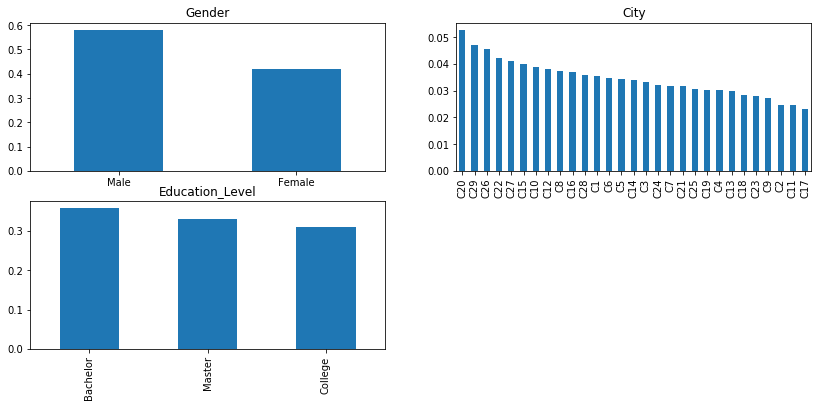

In [10]:
# Univariate Analysis
plt.figure(1)
plt.subplot(221)
df['Gender'].value_counts(normalize=True).plot.bar(figsize=(14,6),title='Gender')
plt.xticks(rotation=360)
plt.subplot(222)
df['City'].value_counts(normalize=True).plot.bar(title='City')
plt.subplot(223)
df['Education_Level'].value_counts(normalize=True).plot.bar(title='Education_Level')


#### Observations:

There are more male than female in the dataset

C20 city has more values

People with Bachelors degree is more compared to Masters and College

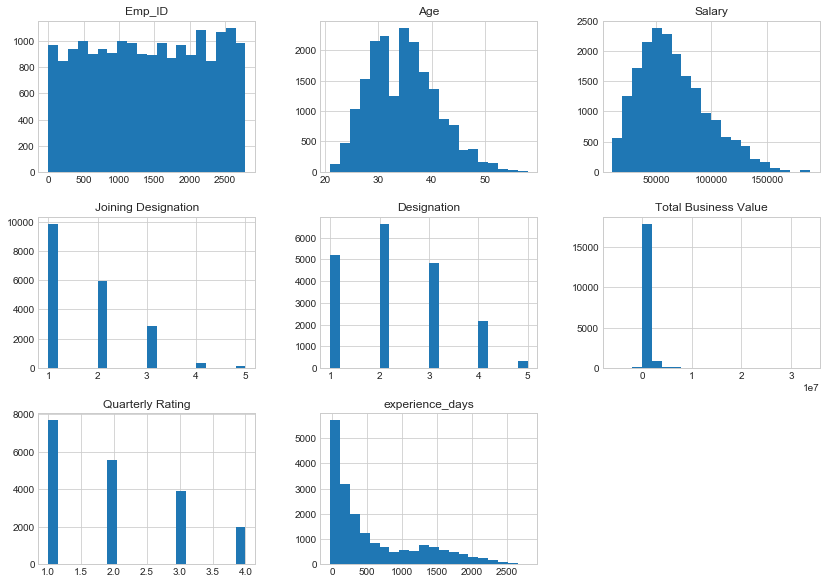

In [11]:
# Numerical Features distribution:

plt.style.use('seaborn-whitegrid')

df.hist(bins=20, figsize=(14,10))
plt.show()


### Observations of numerical featues:

Joining designation majority is 1. That is true as most people will be joining as freshers. 

Designation feature got increased gradually as years pass by

Most people are in salary bracket between 50k to 1 lakh

Experience is right skewed as there are majority of people with less exerience as companies hire freshers more

There are many people with 1 rating which might be the major cause for people leaving the organisation. Getting 1 rating will demotivate people as their work is not acknowledged




In [12]:
df['City']=df.City.str.slice(1)

In [13]:
df.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating,experience_days
0,2016-01-01,1,28,Male,23,Master,57387,2015-12-24,NaT,1,1,2381060,2,8
1,2016-02-01,1,28,Male,23,Master,57387,2015-12-24,NaT,1,1,-665480,2,39
2,2016-03-01,1,28,Male,23,Master,57387,2015-12-24,2016-03-11,1,1,0,2,68
3,2017-11-01,2,31,Male,7,Master,67016,2017-11-06,NaT,2,2,0,1,-5
4,2017-12-01,2,31,Male,7,Master,67016,2017-11-06,NaT,2,2,0,1,25


In [14]:
df["City"]= df["City"].astype('int64')

In [15]:
df.Gender.replace('Female',0,inplace=True)
df.Gender.replace('Male',1,inplace=True)

df.Education_Level.replace('College',0,inplace=True)
df.Education_Level.replace('Bachelor',1,inplace=True)
df.Education_Level.replace('Master',2,inplace=True)


In [16]:
df['experience_days']=abs(df['experience_days'])

In [17]:
df['number_of_promotion'] = df['Designation'] - df['Joining Designation']

In [18]:
#Check if salary has been iincreased
df['Salary_increased']=df.groupby('Emp_ID')['Salary'].diff().gt(0)

In [19]:
# check if rating has been increased
df['Rating increased'] = df.groupby('Emp_ID')['Quarterly Rating'].diff().agg(lambda x: 1 if x > 0 else 0)
# check if rating has been decreased
df['Rating decreased'] = df.groupby('Emp_ID')['Quarterly Rating'].diff().agg(lambda x: 1 if x < 0 else 0)
# create the feature last business value
df['Last Business Value'] = df['Total Business Value'].shift()


In [20]:
# extract the Quarter from Date
df['Quarter'] = df.iloc[:,0].dt.to_period('Q')


In [21]:
df.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating,experience_days,number_of_promotion,Salary_increased,Rating increased,Rating decreased,Last Business Value,Quarter
0,2016-01-01,1,28,1,23,2,57387,2015-12-24,NaT,1,1,2381060,2,8,0,False,0,0,NaN,2016Q1
1,2016-02-01,1,28,1,23,2,57387,2015-12-24,NaT,1,1,-665480,2,39,0,False,0,0,2381060.0,2016Q1
2,2016-03-01,1,28,1,23,2,57387,2015-12-24,2016-03-11,1,1,0,2,68,0,False,0,0,-665480.0,2016Q1
3,2017-11-01,2,31,1,7,2,67016,2017-11-06,NaT,2,2,0,1,5,0,False,0,0,0.0,2017Q4
4,2017-12-01,2,31,1,7,2,67016,2017-11-06,NaT,2,2,0,1,25,0,False,0,0,0.0,2017Q4


In [22]:
df['Last Business Value']=df['Last Business Value'].fillna(0)

In [23]:
#extract the Target feature
attrition_status=df.groupby(['Emp_ID','Quarter'])['LastWorkingDate'].last().agg(lambda x:int(pd.notna(x)))

In [24]:
att_status=df.groupby(['Emp_ID','Quarter'])['LastWorkingDate'].last()

In [25]:
att_status

Emp_ID  Quarter
1       2016Q1    2016-03-11
2       2017Q4           NaT
4       2016Q4           NaT
        2017Q1           NaT
        2017Q2    2017-04-27
                     ...    
2787    2016Q1           NaT
        2016Q2    2016-06-20
2788    2017Q2           NaT
        2017Q3           NaT
        2017Q4           NaT
Name: LastWorkingDate, Length: 7357, dtype: datetime64[ns]

In [26]:
attrition_status

Emp_ID  Quarter
1       2016Q1     1
2       2017Q4     0
4       2016Q4     0
        2017Q1     0
        2017Q2     1
                  ..
2787    2016Q1     0
        2016Q2     1
2788    2017Q2     0
        2017Q3     0
        2017Q4     0
Name: LastWorkingDate, Length: 7357, dtype: int64

In [27]:
last_quart = max(df['Quarter'].unique())


In [28]:
last_quart

Period('2017Q4', 'Q-DEC')

In [29]:
def get_group(g,key1,key2):
    try:
        return g[key1][key2]
    except:
        return 0

In [30]:
get_group(attrition_status, 4, '2016Q4')

0

In [31]:
for i in range(df.shape[0]):
    curr_quart=df.loc[i,'Quarter']
    emp_id=df.loc[i,'Emp_ID']
    #print('Emp_id:', emp_id,'Current_Quarter', curr_quart)
    #print('Attr:',attrition_status[emp_id][curr_quart])
    if attrition_status[emp_id][curr_quart]==1:
        df.loc[i,'Attrition']=1
    elif ((curr_quart+1))<=last_quart and get_group(attrition_status, emp_id, curr_quart+1):
        df.loc[i,'Attrition']=1
    elif ((curr_quart+2))<=last_quart and get_group(attrition_status, emp_id, curr_quart+2):
        df.loc[i,'Attrition']=1
    else:
        df.loc[i,'Attrition']=0
    

In [32]:
df['Attrition'] = df['Attrition'].astype('int')
df['Attrition'].value_counts()

0    10711
1     8393
Name: Attrition, dtype: int64

In [33]:
df.head(20)

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,...,Total Business Value,Quarterly Rating,experience_days,number_of_promotion,Salary_increased,Rating increased,Rating decreased,Last Business Value,Quarter,Attrition
0,2016-01-01,1,28,1,23,2,57387,2015-12-24,NaT,1,...,2381060,2,8,0,False,0,0,0.0,2016Q1,1
1,2016-02-01,1,28,1,23,2,57387,2015-12-24,NaT,1,...,-665480,2,39,0,False,0,0,2381060.0,2016Q1,1
2,2016-03-01,1,28,1,23,2,57387,2015-12-24,2016-03-11,1,...,0,2,68,0,False,0,0,-665480.0,2016Q1,1
3,2017-11-01,2,31,1,7,2,67016,2017-11-06,NaT,2,...,0,1,5,0,False,0,0,0.0,2017Q4,0
4,2017-12-01,2,31,1,7,2,67016,2017-11-06,NaT,2,...,0,1,25,0,False,0,0,0.0,2017Q4,0
5,2016-12-01,4,43,1,13,2,65603,2016-12-07,NaT,2,...,0,1,6,0,False,0,0,0.0,2016Q4,1
6,2017-01-01,4,43,1,13,2,65603,2016-12-07,NaT,2,...,0,1,25,0,False,0,0,0.0,2017Q1,1
7,2017-02-01,4,43,1,13,2,65603,2016-12-07,NaT,2,...,0,1,56,0,False,0,0,0.0,2017Q1,1
8,2017-03-01,4,43,1,13,2,65603,2016-12-07,NaT,2,...,350000,1,84,0,False,0,0,0.0,2017Q1,1
9,2017-04-01,4,43,1,13,2,65603,2016-12-07,2017-04-27,2,...,0,1,115,0,False,0,0,350000.0,2017Q2,1


In [34]:
df['Salary_increased'] = df['Salary_increased'].astype('category').cat.codes

In [35]:
data = df.drop(columns = ['Dateofjoining', 'LastWorkingDate', 'Joining Designation', 'City', 'Quarter'])


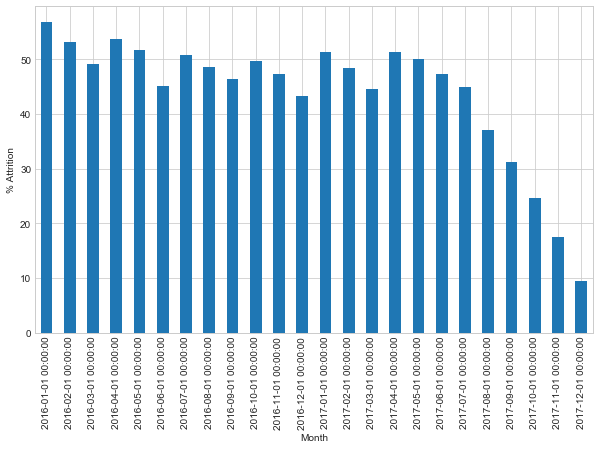

In [36]:
# check attrition by month
Attrition_by_month = data.groupby(['MMM-YY'])['Attrition'].agg(lambda x: x.sum() * 100 / x.count())
Attrition_by_month.plot(kind = 'bar', ylabel='% Attrition',
         xlabel='Month', figsize=(10, 6))


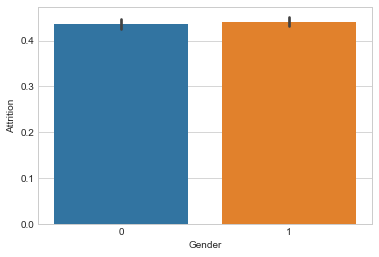

In [37]:
sns.barplot(x = 'Gender', y = 'Attrition', data = data)

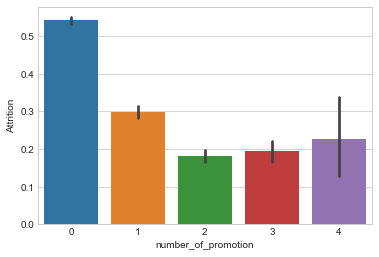

In [38]:
sns.barplot(x = 'number_of_promotion', y = 'Attrition', data = data)


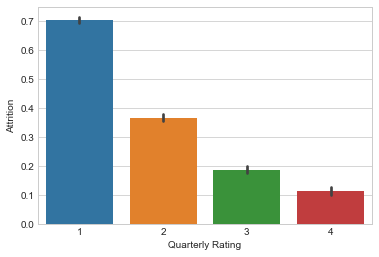

In [39]:
sns.barplot(x = 'Quarterly Rating', y = 'Attrition', data = data)

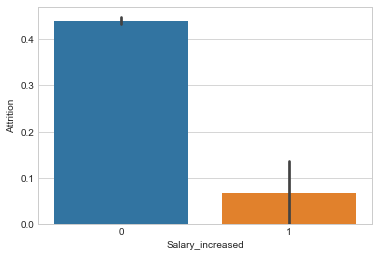

In [40]:
sns.barplot(x = 'Salary_increased', y = 'Attrition', data = data)

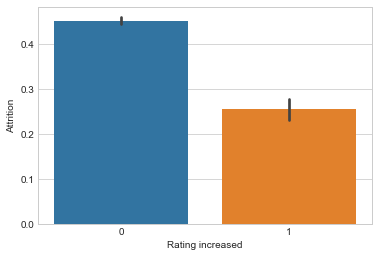

In [41]:
sns.barplot(x = 'Rating increased', y = 'Attrition', data = data)

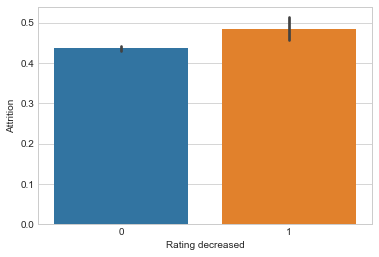

In [42]:
sns.barplot(x = 'Rating decreased', y = 'Attrition', data = data)

In [43]:
#data = data.sort_values(['MMM-YY', 'Attrition'], ascending=[True, False])

In [44]:
data_dec17 = data[data['MMM-YY'] == '2017-12-01']
test_data = pd.DataFrame({'Emp_ID': test.iloc[:, 0]}).merge(data_dec17)
test_data = test_data.drop(columns = ['Attrition'])


In [45]:
train_data = data[data['MMM-YY'] != '2017-12-01'] 

In [46]:
test_data.head()

,Emp_ID,MMM-YY,Age,Gender,Education_Level,Salary,Designation,Total Business Value,Quarterly Rating,experience_days,number_of_promotion,Salary_increased,Rating increased,Rating decreased,Last Business Value
0,394,2017-12-01,34,0,2,97722,4,2701750,3,2370,2,0,0,0,1433660.0
1,173,2017-12-01,39,1,0,56174,3,706010,3,2363,2,0,0,0,1102120.0
2,1090,2017-12-01,39,1,0,96750,4,1518520,2,2349,2,0,0,0,562170.0
3,840,2017-12-01,40,0,0,88813,4,1151820,2,2335,3,0,0,0,278340.0
4,308,2017-12-01,32,1,2,188418,5,3772910,2,2300,3,0,0,0,1037000.0


In [47]:
train_data.head()

,MMM-YY,Emp_ID,Age,Gender,Education_Level,Salary,Designation,Total Business Value,Quarterly Rating,experience_days,number_of_promotion,Salary_increased,Rating increased,Rating decreased,Last Business Value,Attrition
0,2016-01-01,1,28,1,2,57387,1,2381060,2,8,0,0,0,0,0.0,1
1,2016-02-01,1,28,1,2,57387,1,-665480,2,39,0,0,0,0,2381060.0,1
2,2016-03-01,1,28,1,2,57387,1,0,2,68,0,0,0,0,-665480.0,1
3,2017-11-01,2,31,1,2,67016,2,0,1,5,0,0,0,0,0.0,0
5,2016-12-01,4,43,1,2,65603,2,0,1,6,0,0,0,0,0.0,1


In [48]:
train_data['Attrition'].value_counts()

0    9970
1    8315
Name: Attrition, dtype: int64

In [49]:
train_data=train_data.drop(['Emp_ID'],axis=1)

In [50]:
test_data=test_data.drop(['Emp_ID'],axis=1)

In [51]:
train_data=train_data.drop(['MMM-YY'],axis=1)
test_data=test_data.drop(['MMM-YY'],axis=1)

In [52]:
X=train_data.drop('Attrition',axis=1)
y=train_data['Attrition']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

In [54]:
dtc=DecisionTreeClassifier()

In [55]:
dtc.fit(X_train,y_train)

DecisionTreeClassifier()

In [56]:
dtpred=dtc.predict(X_test)

In [57]:
f1_score(y_test,dtpred)

0.752071125479895

In [58]:
clf = AdaBoostClassifier(random_state = 1)

In [59]:
clf.fit(X_train, y_train)

AdaBoostClassifier(random_state=1)

In [60]:
y_pred = clf.predict(X_test)

In [61]:
f1_score(y_test,y_pred)

0.7180829641562626

In [62]:
rfc=RandomForestClassifier()

In [63]:
rfc.fit(X_train,y_train)

RandomForestClassifier()

In [64]:
rfc_predictions = rfc.predict(X_test)

In [65]:
print(classification_report(y_test, rfc_predictions))

              precision    recall  f1-score   support

           0       0.81      0.84      0.83      2991
           1       0.80      0.77      0.78      2495

    accuracy                           0.81      5486
   macro avg       0.81      0.81      0.81      5486
weighted avg       0.81      0.81      0.81      5486

